## Packages & Preamble

We first load all packages: note that we ignore FutureWarning due to pyfolio

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from tqdm import tqdm
from return_utils import factors_to_pos,pos_to_return,collecting_stock_data_avg,spearman_corr,collecting_stock_percentages
import os
import seaborn as sns
import matplotlib.pyplot as plt
import empyrical

/usr/local/Caskroom/miniconda/base/envs/tdasp500/lib/python3.9/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
%load_ext autoreload
%autoreload 2

Load the list of tickers: note that we remove all appearing post 2017 to avoid
selection bias.

In [3]:
s_and_p = pd.read_csv('csvs/sp500/sp500_tickers.csv').iloc[:, 1]
s_and_p = list(s_and_p.map(
    lambda x: x.replace('\n', '')).values)
post_2017=['KDP','FOXA','ON','VICI','CPT','MOH','NDSN','CEG','SBNY','SEDG','FDS','EPAM','MTCH','CDAY','BRO','TECH','MRNA','OGN'
            ,'CRL','PTC','NXPI','PENN','GNRC','CZR','MPWR','TRMB','ENPH','TSLA','VNT','POOL','ETSY','TER','CTLT','BIO','TDY','TYL'
            ,'WST','DPZ','DXCM','OTIS','CARR','HWM','IR','PAYC','LYV',"ZBRA",'STE','ODFL','WRB','NOW','LVS','NVR','CDW','LDOS','IEX','TMUS'
            ,'MKTX','AMCRT','DD','CTVA','DOW','WAB','ATO','TFX','FRC','CE','LW','MXIM','FANG','JKHY','KEYS','FTNT','ROL','WCG','ANET','CPRT','FLT','BR'
            ,'HFC',"TWTR",'EVRG','ABMD','MSCI','TTWO','SIVB','NKTR','IPGP','HII','NCLH','CDNS','DWDP','SBAC','Q','BHF','DRE','AOS','PKG','RMD'
            ,'MGM','HLT','ALGN','ANSS','RE','INFO']
s_and_p=list(set(s_and_p)-set(post_2017))
post_2017=list(set(s_and_p)&set(post_2017))

Collect stock close and returns

In [4]:
stock_closes_df = collecting_stock_data_avg(tickers=s_and_p)
stock_closes_df.to_csv('csvs/sp500/collected_stock_closes.csv')
stock_closes_df.index=pd.to_datetime(stock_closes_df.index.values,format='%Y-%m-%d')
stock_closes_df.fillna(stock_closes_df.mean(axis=1),inplace=True)
stock_perc_df = collecting_stock_percentages(s_and_p)
stock_perc_df.index=pd.to_datetime(stock_perc_df.index.values,format='%Y-%m-%d')
stock_perc_df.fillna(stock_perc_df.mean(axis=1),inplace=True)
stock_closes_rets_df=pd.concat([stock_closes_df,stock_perc_df],axis=1)
stock_closes_rets_df.to_csv('csvs/sp500/collected_stock_closes_and_percentage_returns.csv')


Collect bnh returns only

In [5]:
bnh_returns_df=stock_perc_df.mean(axis=1)
bnh_returns_df.to_csv('csvs/sp500/bnh_returns.csv')

This will be used to collect various factors

In [6]:
def factor_collecting(tickers, col='Avg_Betti',inputpath='Betti_experiments/betti_dim_3_points_7'):
    fact_df = pd.DataFrame(dtype=np.float64)
    for t in tqdm(tickers):
        df = pd.read_csv(inputpath+t+'.csv', index_col=0)
        df2 = pd.DataFrame({t: df[col]}, index=df.index)
        fact_df = pd.concat([fact_df, df2], axis=1)
    fact_df.index.name='Date'
    return(fact_df)

# Optimising Embedding Dim

In [7]:
dimlow = 2
dimup = 6
pointlow = 5
pointup = 9
outpath = 'Betti_experiments'

In [8]:
for d in range(dimlow, dimup+1):
    for point in range(pointlow, pointup+1):
        if not os.path.exists(f'{outpath}/Sharpe_values/betti_dim_{d}_points_{point}'):
            os.makedirs(
                    f'{outpath}/Sharpe_values/betti_dim_{d}_points_{point}')

Using values calculate meandiff & sort factors

In [10]:
for d in range(dimlow, dimup+1):
    for point in tqdm(range(pointlow, pointup+1)):
        data_read=f'{outpath}/betti_dim_{d}_points_{point}/'
        data_output=f'{outpath}/Sharpe_values/betti_dim_{d}_points_{point}/'
        if not os.path.exists(f'{data_output}relative_betti_values.csv'):   
            unweighted_betti_df=factor_collecting(tickers=s_and_p,col='Avg_Rel_%_Betti',inputpath=data_read)
            unweighted_betti_df.to_csv(f'{data_output}relative_betti_values.csv')   
        else: 
            unweighted_betti_df=pd.read_csv(f'{data_output}relative_betti_values.csv',index_col=0)
        # if not os.path.exists(f"{data_output}relative_unweighted_prop_factors.csv"):
        #     prop_factors_df=unweighted_betti_df.rolling(window=d*point).apply(proportional_corr)
        #     prop_factors_df.to_csv(f"{data_output}relative_unweighted_prop_factors.csv")
        if not os.path.exists(f"{data_output}relative_sort_factors.csv"):
            sort_factors_df=unweighted_betti_df.rolling(window=d*point).apply(spearman_corr)
            sort_factors_df.to_csv(f"{data_output}relative_sort_factors.csv")
        if not os.path.exists(f"{data_output}relative_meandiff_factors.csv"):
            meandiff_factors_df=unweighted_betti_df-unweighted_betti_df.rolling(window=d*point).mean()
            meandiff_factors_df.to_csv(f"{data_output}relative_meandiff_factors.csv")

100%|██████████| 5/5 [14:46<00:00, 177.32s/it]


Loop over dimension, N_p, and hold length for meandiff/sort strategies,
calculate various strategy return values

In [11]:
avg_values=pd.DataFrame(dtype=np.float64)
for d in range(dimlow, dimup+1):
    for point in range(pointlow, pointup+1):

        data_read=f'{outpath}/Sharpe_values/betti_dim_{d}_points_{point}'
        data_output=f'{outpath}/Sharpe_values/betti_dim_{d}_points_{point}'

        sort_factors_df=pd.read_csv(f"{data_read}/sort_factors.csv",index_col=0)
        sort_factors_df.index.name='Date'
        meandiff_factors_df=pd.read_csv(f"{data_read}/meandiff_factors.csv",index_col=0)
        meandiff_factors_df.index.name='Date'   
        for df in [sort_factors_df,meandiff_factors_df]:
            df.index=pd.to_datetime(df.index.values,format='%Y-%m-%d')
        
        sort_pos=factors_to_pos(stock_factor_df=sort_factors_df, collected_stocks_df=stock_perc_df, tickers=s_and_p, start='2018-01-01', end='2022-06-01')
        md_pos=factors_to_pos(stock_factor_df=meandiff_factors_df, collected_stocks_df=stock_perc_df, tickers=s_and_p, start='2018-01-01', end='2022-06-01')    
        for hold_len in tqdm(range(1,31)):
            if not os.path.exists(f'{data_output}/hold_len_{hold_len}_alpha_beta'):
                sort_rets=pos_to_return(positions_df=sort_pos, tickers=s_and_p, start='2018-01-01', end='2022-06-01',  hold_len=hold_len)
                sort_rets.to_csv(f"{data_output}/sort_hold_len_{hold_len}.csv")

                md_rets=pos_to_return(positions_df=md_pos, tickers=s_and_p, start='2018-01-01', end='2022-06-01',  hold_len=hold_len)
                md_rets.to_csv(f"{data_output}/meandiff_hold_len_{hold_len}.csv")

                valdf=pd.DataFrame({
                    'Dimension':[d,d],
                    'N_p':[point,point],
                    'Hold length':[hold_len,hold_len],
                    'Sharpe ratio':[empyrical.sharpe_ratio(sort_rets),empyrical.sharpe_ratio(md_rets)],
                    'Sortino ratio':[empyrical.sortino_ratio(sort_rets),empyrical.sortino_ratio(md_rets)],
                    'alpha':[empyrical.alpha(sort_rets,bnh_returns_df),empyrical.alpha(md_rets,bnh_returns_df)],
                    'beta':[empyrical.beta(sort_rets,bnh_returns_df),empyrical.beta(md_rets,bnh_returns_df)]
                },
                index=['sort','meandiff'])
                valdf.index.name='Strategy'
                valdf.to_csv(f'{data_output}/hold_len_{hold_len}_alpha_beta')







            
        

100%|██████████| 30/30 [03:19<00:00,  6.66s/it]


Store this below

In [9]:
avg_values=pd.DataFrame(dtype=np.float64)
for d in range(dimlow, dimup+1):
    for point in range(pointlow, pointup+1):
        for hold_len in range(1,31):
            data_read=f'{outpath}/Sharpe_values/betti_dim_{d}_points_{point}'
            valdf=pd.read_csv(f'{data_read}/hold_len_{hold_len}_alpha_beta',index_col='Strategy')
            avg_values=pd.concat([avg_values,valdf])
avg_values.to_csv(f'{outpath}/Sharpe_values/relative_avg_values')

In [10]:
avg_values

,Dimension,N_p,Hold length,Sharpe ratio,Sortino ratio,alpha,beta
Strategy,,,,,,,
sort,2,5,1,0.666834,0.915040,0.001216,1.002794
meandiff,2,5,1,0.719659,0.999651,0.013288,1.000556
sort,2,5,2,0.683146,0.943615,0.004864,0.994872
meandiff,2,5,2,0.668868,0.931514,0.001627,0.990674
sort,2,5,3,0.713156,0.984193,0.007199,0.997319
...,...,...,...,...,...,...,...
meandiff,6,9,28,0.720020,0.998861,0.008429,0.996882
sort,6,9,29,0.686260,0.951944,0.004638,1.007192
meandiff,6,9,29,0.715373,0.991152,0.011082,0.993006


Now we'll plot to see the relationshio

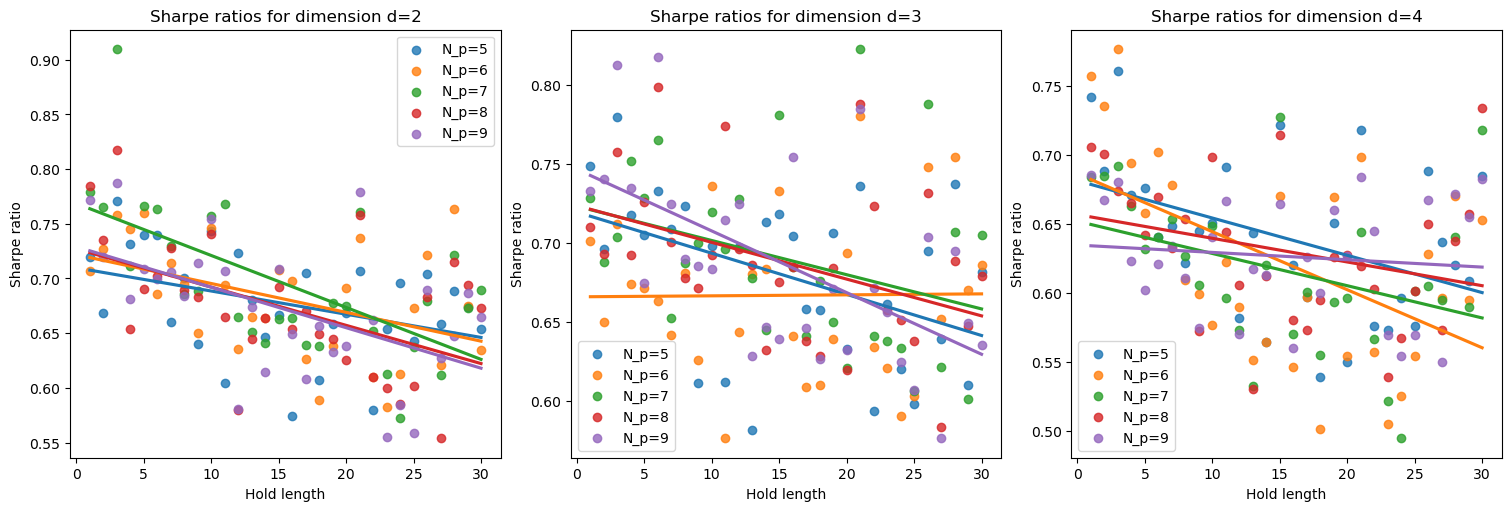

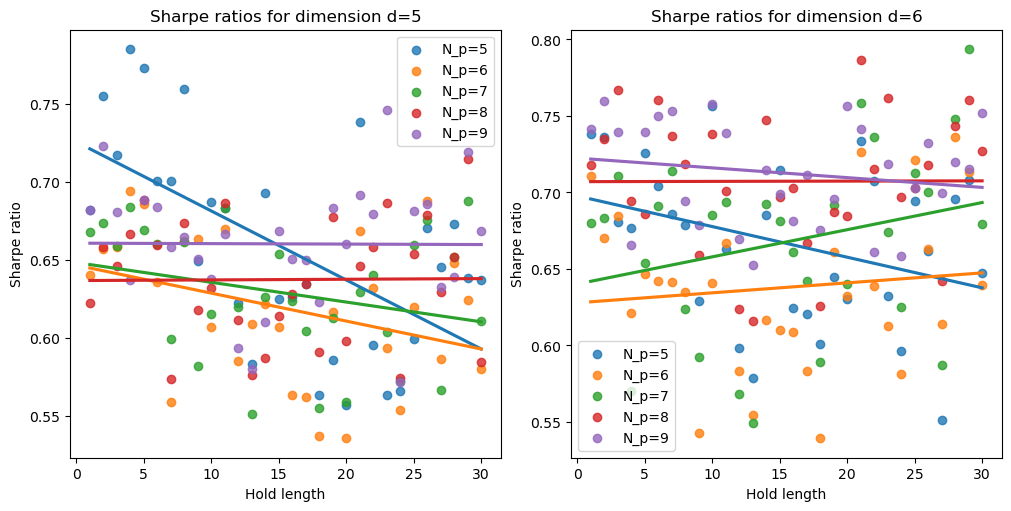

In [11]:
fig1,ax1=plt.subplots(1,3,figsize=(15,5),constrained_layout=True)
fig2,ax2=plt.subplots(1,2,figsize=(10,5),constrained_layout=True)
ax=[ax1[0],ax1[1],ax1[2],ax2[0],ax2[1]]

(
    avg_values.loc[avg_values.index.values=='meandiff']
    .groupby(['Dimension','N_p'])
    .apply(
        lambda df: sns.regplot(
            data=df,
            x='Hold length',
            y='Sharpe ratio',
            ci=None,
            ax=ax[df.Dimension.values[0]-2],
            label=f'N_p={df.N_p.values[0]}').set(title=f'Sharpe ratios for dimension d={df.Dimension.values[0]}')
    )
)
for i in range(5):
    ax[i].legend()

In [23]:
max_df=(
    avg_values
    .loc[lambda df:   (df['Hold length']==21)
    &
            (df['N_p']==7)
        ])
max_df=max_df.reset_index().set_index('Dimension')
print(max_df[['Strategy','Sharpe ratio','Sortino ratio','alpha','beta']].to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  Strategy &  Sharpe ratio &  Sortino ratio &     alpha &      beta \\
Dimension &           &               &                &           &           \\
\midrule
2         &      sort &      0.725615 &       1.007175 &  0.009562 &  0.980370 \\
2         &  meandiff &      0.760386 &       1.060534 &  0.017488 &  0.988180 \\
3         &      sort &      0.734450 &       1.023072 &  0.011749 &  0.988124 \\
3         &  meandiff &      0.822919 &       1.151761 &  0.032260 &  0.996488 \\
4         &      sort &      0.541431 &       0.743908 & -0.031501 &  1.000829 \\
4         &  meandiff &      0.644069 &       0.889151 & -0.008814 &  1.001497 \\
5         &      sort &      0.603932 &       0.828321 & -0.018038 &  1.027934 \\
5         &  meandiff &      0.629385 &       0.867670 & -0.011605 &  0.982195 \\
6         &      sort &      0.716121 &       0.985726 &  0.007734 &  0.998965 \\
6         &  meandiff &      0.758470 &       1.053206 &  0.017